# Process author affiliation countries

Here we want to look at collaborations at the country granularity. A structured XML for each articles comes from running [Cermine](https://github.com/CeON/CERMINE) over the set of articles. Each XML includes author affiliation country codes, so we extract these then process them further.

In particular, for our subsequent network visualization we need to create two list of counts:
1. counts of how many times pairs of countries appear on an article together
2. counts of how many times a country has at least one author on an article

We also first look at how many papers have authors from 1, 2, 3, ... countries.

In [1]:
import os
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
dir_name = r"pdf_processed"  # dir of articles processed by Cermine
articles_dir = os.path.join(base_dir, dir_name)

In [3]:
def get_affiliation_countries(xml_root):
    """
    Returns a list of 2-letter country codes that Cermine found in the affiliations. This function
    just looks at the Cermine XML and extracts these country codes when they are present.
    :param xml_root: root of xml parse
    :return: a list of country codes listed in affiliations; list may be empty
    """
    countries = []
    for contrib_group in xml_root.iter('contrib-group'):
        for contrib_child in contrib_group:
            if contrib_child.tag == 'aff':
                for aff_child in contrib_child:
                    if aff_child.tag == 'country':
                        if 'country' in aff_child.attrib:
                            country = aff_child.attrib['country']
                            countries.append(country)
    return countries

def remove_extension(filename):
    if filename:
        return str(filename).rsplit(sep='.', maxsplit=1)[0]
    return np.NaN

In [4]:
xml_filenames = []
country_codes = []

for root, dirs, files in os.walk(articles_dir):
    # ignore files that aren't Cermine XMLs
    files[:] = [f for f in files if os.path.splitext(f)[1] == '.cermxml']
    for filename_xml in files:
        xml_filenames.append(filename_xml)
        filename_raw = remove_extension(filename_xml)
        path_to_xml = os.path.join(root,filename_xml)
        tree = ET.parse(path_to_xml)
        xmlroot = tree.getroot()
        # extract author affiliation countries from Cermine XML
        countries = get_affiliation_countries(xmlroot)
        if countries:
            country_codes.append(countries)
        else:
            country_codes.append(np.NaN)
            

In [5]:
df = pd.DataFrame({'filenames':xml_filenames, 'country_codes':country_codes})
df.head()

,filenames,country_codes
0,10037815.cermxml,[US]
1,10070331.cermxml,"[NL, NL]"
2,10077222.cermxml,[JP]
3,10077547.cermxml,[CH]
4,10084322.cermxml,"[AU, US]"


In [6]:
print("We have %s XML files from Cermine of which %s contain country codes." %(df.shape[0], 
                                                                  df['country_codes'].notnull().sum()))

We have 3785 XML files from Cermine of which 3093 contain country codes.


In [7]:
country_codes_not_null = df[df['country_codes'].notnull()]['country_codes'].tolist()
# we don't care about same-country collaborations, so make a set of country codes for each article
cc_sets = [set(cc_list) for cc_list in country_codes_not_null]
len(cc_sets)

3093

### Multi-country vs single-country publications
We look at how many articles have more than one country involved, out of the ones where we have affiliation countries extracted. Anything with more than 1 country counts as a multi-country collaboration.

In [8]:
collab_counts = pd.Series((len(cc_set) for cc_set in cc_sets))
collab_counts.value_counts().sort_index()

1     2045
2      687
3      223
4       72
5       28
6       20
7        6
8        5
9        2
10       2
12       2
13       1
dtype: int64

Text(0, 0.5, 'Number of publications')

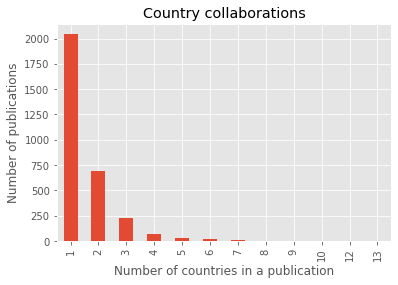

In [9]:
ax = collab_counts.value_counts().sort_index().plot(kind='bar', title='Country collaborations')
ax.set_xlabel("Number of countries in a publication")
ax.set_ylabel("Number of publications")

In [10]:
collaborations = pd.Series(data=[2045/3093, 1048/3093], index=['one country', 'multiple countries'])
collaborations

one country           0.66117
multiple countries    0.33883
dtype: float64

So, in summary:
- almost exactly one-third of publications (which have country codes) are a multi-country collaboration
- the remaining two-thirds have all authors from a single country

### Counts of pairs of countries collaborating

We use the tool 'itertools.combinations' to get all pairs from a set of country codes.

In [11]:
import itertools

list_of_all_pairs = []
for cc_set in cc_sets:
    if len(cc_set) > 1:
        list_of_all_pairs.extend(list(itertools.combinations(cc_set, 2)))


In [12]:
# IMPORTANT: we need to sort each item alphabetically so that each pair and 'reverse' pair are the same
list_pairs_sorted = [tuple(sorted(cc_pair)) for cc_pair in list_of_all_pairs]
pairs_series = pd.Series(list_pairs_sorted)
pairs_series[:10]

0    (AU, US)
1    (CN, UK)
2    (JP, US)
3    (FI, SE)
4    (GR, SE)
5    (FI, GR)
6    (GR, SE)
7    (NL, UK)
8    (DK, UK)
9    (JP, UK)
dtype: object

In [13]:
# most common collaborations
pair_counts = pairs_series.value_counts()
print("We have %s unique country pairs." %pair_counts.shape[0])
pair_counts[:20]

We have 468 unique country pairs.


(DE, US)    122
(UK, US)     95
(CA, US)     79
(DE, UK)     64
(IT, US)     60
(ES, US)     60
(NL, US)     58
(FR, US)     49
(JP, US)     49
(DE, NL)     48
(SE, US)     43
(CH, DE)     42
(CN, US)     40
(AU, US)     39
(CA, UK)     39
(NL, UK)     38
(DE, ES)     37
(CH, US)     36
(FR, UK)     35
(CA, DE)     35
dtype: int64

In [14]:
# sample from the bottom of the list
pair_counts[-10:]

(LB, US)    1
(BE, KR)    1
(BR, PR)    1
(ES, UY)    1
(BR, PL)    1
(BE, PL)    1
(DK, HK)    1
(CH, IR)    1
(CO, NL)    1
(BR, SG)    1
dtype: int64

In [15]:
# re-format and export for making a network graph
df_counts = pair_counts.rename_axis('pairs').reset_index(name='weight')
df_counts[['source', 'target']] = df_counts['pairs'].apply(pd.Series)
df_counts = df_counts.drop(labels='pairs', axis=1)
df_counts = df_counts[['source', 'target', 'weight']]
df_counts.head()

,source,target,weight
0,DE,US,122
1,UK,US,95
2,CA,US,79
3,DE,UK,64
4,IT,US,60


In [16]:
# export to file
df_counts.to_csv('country_collaboration_counts.tsv', sep='\t', index=False, encoding='utf-8')

### Counts of all countries

Here we start from the full list of countries (i.e. not just multi-country papers) and build a frequency dict of how any times a country appears at least once on a publication.

In [17]:
cc_sets[:10]

[{'US'},
 {'NL'},
 {'JP'},
 {'CH'},
 {'AU', 'US'},
 {'JP'},
 {'US'},
 {'JP'},
 {'UK'},
 {'FI'}]

In [18]:
dict_counts = {}
for cc_set in cc_sets:
    for cc in cc_set:
        if cc not in dict_counts:
            dict_counts[cc] = 0
        dict_counts[cc] += 1

# length is the number of unique countries
len(dict_counts)

67

In [19]:
country_counts = pd.DataFrame(list(dict_counts.items()), columns=['id', 'count'])
country_counts = country_counts.sort_values(by='count', ascending=False)
# print the top ten most common
country_counts.head(n=10)

,id,count
0,US,1215
13,DE,523
5,UK,375
1,NL,265
2,JP,243
8,FR,211
18,CA,204
21,IT,177
10,SE,161
6,FI,156


In [20]:
# add continent info for use in the network graph: get info from GeoNames country file
df_countries = pd.read_csv('countryInfo_20180718_clean.txt', sep='\t', quotechar='"', 
                           encoding='utf-8', na_values=['','NaN'], keep_default_na=False)
print("We have info for %s countries." %df_countries.shape[0])
df_countries.head()

We have info for 252 countries.


,ISO,ISO3,ISO-Numeric,fips,Country,Capital,Area(in sq km),Population,Continent,tld,CurrencyCode,CurrencyName,Phone,Postal Code Format,Postal Code Regex,Languages,geonameid,neighbours,EquivalentFipsCode
0,AD,AND,20,AN,Andorra,Andorra la Vella,468.0,84000,EU,.ad,EUR,Euro,376,AD###,^(?:AD)*(\d{3})$,ca,3041565,"ES,FR",NaN
1,AE,ARE,784,AE,United Arab Emirates,Abu Dhabi,82880.0,4975593,AS,.ae,AED,Dirham,971,NaN,NaN,"ar-AE,fa,en,hi,ur",290557,"SA,OM",NaN
2,AF,AFG,4,AF,Afghanistan,Kabul,647500.0,29121286,AS,.af,AFN,Afghani,93,NaN,NaN,"fa-AF,ps,uz-AF,tk",1149361,"TM,CN,IR,TJ,PK,UZ",NaN
3,AG,ATG,28,AC,Antigua and Barbuda,St. John's,443.0,86754,NA,.ag,XCD,Dollar,+1-268,NaN,NaN,en-AG,3576396,NaN,NaN
4,AI,AIA,660,AV,Anguilla,The Valley,102.0,13254,NA,.ai,XCD,Dollar,+1-264,NaN,NaN,en-AI,3573511,NaN,NaN


In [21]:
df_countries['Continent'].value_counts()

AF    58
EU    54
AS    51
NA    42
OC    28
SA    14
AN     5
Name: Continent, dtype: int64

In [22]:
# cross-check the lists of country codes
ccs_table = country_counts['id'].tolist()
ccs_geonames = df_countries['ISO'].tolist()
# which country codes from our counts table don't appear exactly as is in the geonames data?
for cc in ccs_table:
    if cc not in ccs_geonames:
        print(cc)
        

UK


In [23]:
# create our mapping of country codes to continents
cc_to_continent = {}
for index, row in df_countries.iterrows():
    cc_to_continent[row['ISO']] = row['Continent']
    
# manually add the UK
cc_to_continent['UK'] = 'EU'

In [24]:
# add continent info (codes) to our country counts data
def get_continent(countrycode_string):
    if str(countrycode_string) == 'nan':
        return np.NaN
    return cc_to_continent[countrycode_string]

country_counts['continent_code'] = country_counts['id'].apply(get_continent)
country_counts['continent_code'].value_counts()

EU    32
AS    16
AF     7
SA     6
NA     4
OC     2
Name: continent_code, dtype: int64

In [25]:
# add continent names to our country counts data
def get_continent_name(continent_code):
    if continent_code == 'EU':
        return 'Europe'
    if continent_code == 'AS':
        return 'Asia'
    if continent_code == 'AF':
        return 'Africa'
    if continent_code == 'SA':
        return 'South America'
    if continent_code == 'NA':
        return 'North America'
    if continent_code == 'OC':
        return 'Oceania'

country_counts['continent'] = country_counts['continent_code'].apply(get_continent_name)
country_counts['continent'].value_counts()

Europe           32
Asia             16
Africa            7
South America     6
North America     4
Oceania           2
Name: continent, dtype: int64

In [26]:
# export to file
country_counts.to_csv('country_total_counts_with_continent.tsv', sep='\t', index=False, encoding='utf-8')